<a href="https://colab.research.google.com/github/MichaelAshton/iEEG/blob/master/KE_CNN_dogs_momentum_tfRecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Epileptic seizure prediction
---
Based on Kaggle competition American Epilepsy Society Seizure Prediction Challenge
https://www.kaggle.com/c/seizure-prediction

In [0]:
#Importing libraries
import os, sys, pickle, itertools

#import joblib

import numpy as np
import math as math

from scipy.io import loadmat
from scipy.signal import resample #, butter, lfilter

import sklearn.linear_model

import sklearn.metrics
from sklearn.preprocessing import StandardScaler

In [2]:
#Check if we have a GPU

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#Check the versions - from my good friend Dat Nguyen

print('Python version: %s' % sys.version.split(' ')[0])
print('TensorFlow version: %s' % tf.__version__)

Python version: 3.6.8
TensorFlow version: 1.15.0


## Download Dataset using Kaggle API##

---
(This whole section for getting data from Kaggle is borrowed from my good friend Dat Nguyen)

### Step 1: Create a API Token in Kaggle Account 

* Go to Kaggle --> My Account --> Create New API Token

* Reference:  https://stackoverflow.com/questions/49310470/using-kaggle-datasets-into-google-colab


### Step 2: Upload your `kaggle.json` to Google Colab
 
 * Your kaggle.json is a "key" to let you use Kaggle API to download dataset from their website.
 
 
 ### Step 3: Download `American Epilespy Seizure` Dataset (Only the Dog Version for now)



In [5]:
# !rm kaggle.json

rm: cannot remove 'kaggle.json': No such file or directory


In [6]:
# Install the Kaggle API client
!pip install -q kaggle
!apt-get install pv  >> /dev/null    # extract .tar file
# Upload Json File
if not os.path.isfile('kaggle.json'):
  from google.colab import files
  files.upload() 

Saving kaggle.json to kaggle.json


In [9]:
# The Kaggle API client expects this file to be in ~/.kaggle 
%%bash

mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json  #  avoids a warning on Kaggle tool startup.

printf "American Epilepsy Dataset:\n\n"
kaggle competitions files seizure-prediction 

#printf "\nStarting to download all dataset...\n"
#kaggle competitions download seizure-prediction

# To download a particular file. Use: 
#kaggle competitions download seizure-prediction -f Dog_5.tar.gz
kaggle competitions download seizure-prediction -f Dog_4.zip

American Epilepsy Dataset:

name                   size  creationDate         
--------------------  -----  -------------------  
sampleSubmission.csv  117KB  2019-03-07 23:20:43  
Dog_5.zip               3GB  2019-03-07 23:22:42  
Dog_1.zip               4GB  2019-03-07 23:23:38  
Dog_4.zip               9GB  2019-03-07 23:25:27  
Dog_2.zip               6GB  2019-03-07 23:24:03  
Patient_1.zip          14GB  2019-03-07 23:26:20  
Dog_3.zip               9GB  2019-03-07 23:25:54  
Patient_2.zip          15GB  2019-03-07 23:26:43  



100%|##########| 9.32G/9.32G [02:00<00:00, 68.2MB/s]


In [10]:
DATASET_DIR = './output'

if not os.path.isdir(DATASET_DIR):
  os.mkdir(DATASET_DIR)
  
print('Extracting Dog_4')
#!pv  Dog_5.tar.gz | tqdm --unit B --bytes --unit_scale --total $(du -sb Dog_5.tar.gz | awk '{print $1}')| tar xzf - -C output
# !pv  Dog_4.tar.gz | tqdm --unit B --bytes --unit_scale --total $(du -sb Dog_4.tar.gz | awk '{print $1}')| tar xzf - -C output
!unzip Dog_4.zip


Extracting Dog_4
Archive:  Dog_4.zip
   creating: Dog_4/
  inflating: Dog_4/Dog_4_test_segment_0136.mat  
  inflating: Dog_4/Dog_4_interictal_segment_0039.mat  
  inflating: Dog_4/Dog_4_test_segment_0528.mat  
  inflating: Dog_4/Dog_4_test_segment_0761.mat  
  inflating: Dog_4/Dog_4_test_segment_0473.mat  
  inflating: Dog_4/Dog_4_test_segment_0870.mat  
  inflating: Dog_4/Dog_4_test_segment_0224.mat  
  inflating: Dog_4/Dog_4_interictal_segment_0162.mat  
  inflating: Dog_4/Dog_4_interictal_segment_0331.mat  
  inflating: Dog_4/Dog_4_interictal_segment_0178.mat  
  inflating: Dog_4/Dog_4_test_segment_0469.mat  
  inflating: Dog_4/Dog_4_interictal_segment_0566.mat  
  inflating: Dog_4/Dog_4_test_segment_0620.mat  
  inflating: Dog_4/Dog_4_interictal_segment_0674.mat  
  inflating: Dog_4/Dog_4_test_segment_0532.mat  
  inflating: Dog_4/Dog_4_test_segment_0931.mat  
  inflating: Dog_4/Dog_4_test_segment_0635.mat  
  inflating: Dog_4/Dog_4_interictal_segment_0324.mat  
  inflating: Dog_4/

In [0]:
# define global subject (the folder containing a subject's data)
subject = 'Dog_4'

##Content of the file:
* data: a matrix of EEG sample values arranged row x column as electrode x time.
* data_length_sec: the time duration of each data row
* sampling_frequency: the number of data samples representing 1 second of EEG data.
* channels: a list of electrode names corresponding to the rows in the data field
* sequence: the index of the data segment within the one hour series of clips. For example, preictal_segment_6.mat has a sequence number of 6, and represents the iEEG data from 50 to 60 minutes into the preictal data.

In [13]:
#RS
file_name = './{}/{}_preictal_segment_0007.mat'.format(subject, subject)

"""Get input shape in data"""    
if not os.path.isfile(file_name):
  raise IOError('File %s not found' % file_name)
if not isinstance(file_name, str):
    file_name = file_name.decode("utf-8")
mat = loadmat(file_name)
input_id = str(int(file_name.split('_')[-1].split('.')[0]))
for key in mat.keys():
  if 'segment' in key:
    data_info = mat[key]
    print('\tData Length: %d (seconds)' %data_info[0][0][1])
    print('\tSampling Frequency: %f (Hz)' %data_info[0][0][2])
    print('\tChannels: ')
    
    channel_number = len(data_info[0][0][3][0])
    for channel in data_info[0][0][3][0]:
      print('\t\t%s'%str(channel[0]))

	Data Length: 600 (seconds)
	Sampling Frequency: 399.609756 (Hz)
	Channels: 
		NVC1202_26_003_Ecog_c001
		NVC1202_26_003_Ecog_c002
		NVC1202_26_003_Ecog_c003
		NVC1202_26_003_Ecog_c004
		NVC1202_26_003_Ecog_c005
		NVC1202_26_003_Ecog_c006
		NVC1202_26_003_Ecog_c007
		NVC1202_26_003_Ecog_c008
		NVC1202_26_003_Ecog_c009
		NVC1202_26_003_Ecog_c010
		NVC1202_26_003_Ecog_c011
		NVC1202_26_003_Ecog_c012
		NVC1202_26_003_Ecog_c013
		NVC1202_26_003_Ecog_c014
		NVC1202_26_003_Ecog_c015
		NVC1202_26_003_Ecog_c016


In [14]:
#Content of the example file]
m = loadmat('./{}/{}_preictal_segment_0007.mat'.format(subject, subject))
d = m
print(d)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug 21 01:00:00 2014', '__version__': '1.0', '__globals__': [], 'preictal_segment_7': array([[(array([[ -24,   50,   -5, ...,  -16,  -94,   15],
       [  18,   77,   16, ...,   10,   36,    4],
       [ 131,   59,  121, ...,  -43,   26,  -64],
       ...,
       [ -58,    1,  -67, ...,  -10,   31,   29],
       [  33, -102,   20, ...,  -27,   37,  -48],
       [ -65,  -43,  -81, ...,   90,  -64,   63]], dtype=int16), array([[600]], dtype=uint16), array([[399.6097561]]), array([[array(['NVC1202_26_003_Ecog_c001'], dtype='<U24'),
        array(['NVC1202_26_003_Ecog_c002'], dtype='<U24'),
        array(['NVC1202_26_003_Ecog_c003'], dtype='<U24'),
        array(['NVC1202_26_003_Ecog_c004'], dtype='<U24'),
        array(['NVC1202_26_003_Ecog_c005'], dtype='<U24'),
        array(['NVC1202_26_003_Ecog_c006'], dtype='<U24'),
        array(['NVC1202_26_003_Ecog_c007'], dtype='<U24'),
        array(['NVC1202_26_003_Ecog_c00

##Using moving averages to smooth out the data

---
 ### Step 1. Get a list of all the files
 Files with *preictal_segment* in the name contain fragments of pre-seizure (within 1 hour prior to seizure) EEG.
 Files with *interictal_segment* in the name contain fragments of non-seziure/normal EEG.
 ### Step 2. Smooth out each row of the EEG matrix using *momentum* function

 Matrix dimensions: *Rows - Number of electrodes, Columns -  data_length_sec X sampling_frequency*
 
 ### Step 3.  Slide a window through the the smoothed matrix

In [0]:
def momentum (z):
  n_iter = len(z)
  beta = 0.9
  temp = np.zeros((len(z)))
  
  for k in range(1,n_iter-1):
    temp[k+1] = beta * temp[k] + (1-beta) * z[k] 
    
  return temp
  

###Visualize raw and smoothed data
Correct beta in the **momentum** to achieve a smoother curve or vice versa

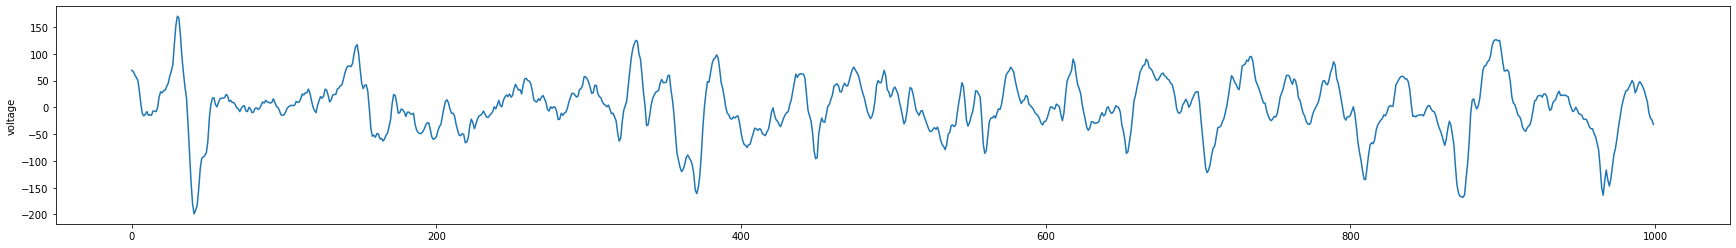

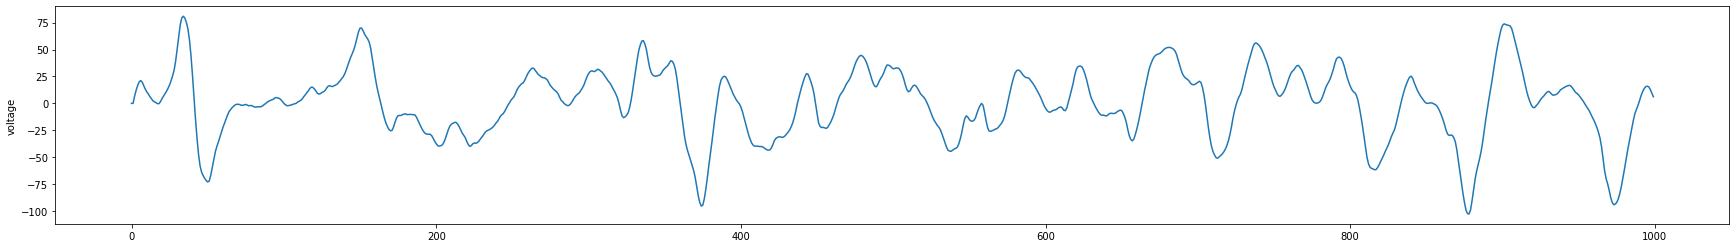

In [18]:
import matplotlib.pyplot as plt

m = loadmat('./{}/{}_preictal_segment_0006.mat'.format(subject, subject))
d = m['preictal_segment_6'][0][0][0]

plt.figure(figsize=(30,4))
plt.plot(d[1][0:1000])

plt.ylabel('voltage')
plt.show()


plt.figure(figsize=(30,4))
plt.plot(momentum(d[1][0:1000]))

plt.ylabel('voltage')
plt.show()

In [0]:
path = '{}/'.format(subject)

#Window size * # of electrode channels gives us number of features - input to the NN
import numpy as np
win_size = 239765 #250 #can be changed 1000


def prepX (fname):
    
    dt_length = 0
    mat_path = path + fname
    rm = loadmat(mat_path)
    
    if 'inter' in fn:
        
        indx=int(fn[25:-4])
        rd = rm['interictal_segment_' + str(indx)][0][0][0]
        dt_length = int(math.floor (rd.shape[1] / win_size))
        Y = [0] * dt_length
    else:
       
        indx=int(fn[23:-4])
        rd = rm['preictal_segment_' + str(indx)][0][0][0]
        dt_length = int(math.floor (rd.shape[1] / win_size))
        Y = [1] * dt_length
    
    #print(dt_length)
    rd_filt = np.zeros((rd.shape[0],rd.shape[1]))

    for j in range(rd.shape[0]):
         rd_filt[j] = momentum(rd[j])
    
    
    data=[]
    for i in range(dt_length):
        data.append (rd_filt[:, i*win_size : i*win_size+win_size])
       
    #RS - changing so we can save the matrix (2D) in the file instead of a vector (1D). This is for 1D CNNs    
    """X = []
    for j in range(dt_length):
        X.append (data[j].reshape(-1,1))
    
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    print(Y.shape)
    data = np.concatenate((X, Y[:, None, None]), axis=1)
    print(data.shape)"""
    
    if 'inter' in fn:
        
        rm['interictal_segment_' + str(indx)][0][0][0] = data
        
    else:
        rm['preictal_segment_' + str(indx)][0][0][0] = data
    
    savemat('{}/{}'.format(preprocessed_dir, fname,), rm)
    
    

        
    return
  

In [0]:
#This is where we'll put prepocessed files
preprocessed_dir = 'processed/{}'.format(subject)
#preprocessed_dir = "gdrive/My Drive/KE"  #/{}".format(subject)

In [0]:
#Run only when getting files from Google Drive
#channel_number = 16
#win_size = 1000

In [0]:
import os
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

In [0]:
# #This part takes a while
# from random import shuffle
# import pickle
# from scipy.io import savemat

# fns  = []

# posit = [fn for fn in os.listdir(path) if 'preictal' in fn]
# negat = [fn for fn in os.listdir(path) if 'interictal' in fn]
# shuffle(negat)

# #for debugging purposes only
# #posit = posit[:4]
# #negat = negat[:4]

# negat = negat[0:int(len(posit)*1.5)]

# fns = posit + negat
# shuffle(fns)

# for fn in fns:
#     print(fn)
#     prepX(fn)
  

In [0]:
# !ls processed/Dog_4

In [0]:
# !du -sh processed/Dog_4

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# !ls gdrive/'My Drive'

In [0]:
# !cp -R processed/Dog_4 gdrive/'My Drive'/KE

In [0]:
# !ls gdrive/'My Drive'/KE/Dog_4

In [0]:
# !ls gdrive/'My Drive'

### tf.Dataset

#### use lists of data paths to split into train and test data

In [0]:
import os
import glob
import pandas as pd
import numpy as np

In [31]:
preprocessed_dir

'processed/Dog_4'

In [0]:
delimiter = '/*.mat'

In [0]:
files = glob.glob('Dog_4' + delimiter)

In [0]:
files = sorted(files)

In [36]:
len(files)

1891

In [0]:
labels_df = pd.DataFrame(data=np.zeros((len(files), 1)), columns=['label'], index=files)

In [0]:
labels_df.label = labels_df.label.astype(int)

In [0]:
for index in labels_df.index:
    if 'interictal' in index:
        labels_df.at[index, 'label'] = 0
    elif 'preictal' in index:
        labels_df.at[index, 'label'] = 1
    elif 'test' in index:
        labels_df.drop(index, inplace=True)

In [40]:
labels_df.shape

(901, 1)

In [41]:
labels_df.label.value_counts()

0    804
1     97
Name: label, dtype: int64

In [42]:
labels_df.head()

,label
Dog_4/Dog_4_interictal_segment_0001.mat,0
Dog_4/Dog_4_interictal_segment_0002.mat,0
Dog_4/Dog_4_interictal_segment_0003.mat,0
Dog_4/Dog_4_interictal_segment_0004.mat,0
Dog_4/Dog_4_interictal_segment_0005.mat,0


In [0]:
#labels_df.drop(labels_df.index.values[30:-30], inplace=True)
#RS
labels_df.drop(labels_df.index.values[labels_df.shape[0]:-labels_df.shape[0]], inplace=True)

In [0]:
labels_df = labels_df.sample(frac=1)

In [45]:
labels_df.label.value_counts()

0    804
1     97
Name: label, dtype: int64

In [0]:
# use a stratified split to ensure train and test set are balanced
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

stratSplit = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)

stratSplit.get_n_splits(labels_df.index, labels_df.label)

for train_idx,test_idx in stratSplit.split(labels_df.index, labels_df.label):
    X_train=labels_df.index[train_idx]
    y_train=labels_df.label[train_idx]
    X_test=labels_df.index[test_idx]
    y_test=labels_df.label[test_idx]

In [47]:
len(X_train)

720

In [48]:
len(X_test)

181

In [49]:
len([x for x in X_train if 'interictal' in x])

642

In [50]:
len([x for x in X_train if 'preictal' in x])

78

In [51]:
len([x for x in X_test if 'interictal' in x])

162

In [52]:
len([x for x in X_test if 'preictal' in x])

19

In [0]:
import os
if not os.path.exists('data_lists'):
    os.makedirs('data_lists')

In [0]:
import numpy as np

def gen_dataset(labels_df, y_train, y_test):
    train_labels_df = labels_df.loc[y_train.index]
    test_labels_df = labels_df.loc[y_test.index]
    
    train_labels_df = train_labels_df.astype(int)
    train_labels_df.reset_index().to_csv(r'data_lists/train.txt', header=None, index=None, sep='#')
    
    test_labels_df = test_labels_df.astype(int)
    test_labels_df.reset_index().to_csv(r'data_lists/test.txt', header=None, index=None, sep='#')
    
gen_dataset(labels_df, y_train, y_test)

#### create tf record from preprocessed mat files

In [0]:
#### create tf record of preprocessed mat files

import tensorflow as tf
# tf.enable_eager_execution()

import os
from scipy.io import loadmat
import numpy as np
import sys

In [0]:
data_dir = './'

train_txt_path = './data_lists/train.txt'
test_txt_path = './data_lists/test.txt'

train_tfrecords_path = 'train_processed.tfrecords'
test_tfrecords_path = 'test_processed.tfrecords'

In [0]:
# functions for converting to relevant data type for tf.Feature
def _float32_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [58]:
"""RS
mat = loadmat( 'processed/Dog_5/Dog_5_interictal_segment_0256.mat' )
for key in mat.keys():
            print(key)
            if 'segment' in key:
                data = mat[key][0][0][0]

                #X = data[:, :-1, :]
print(data.shape)
"""

"RS\nmat = loadmat( 'processed/Dog_5/Dog_5_interictal_segment_0256.mat' )\nfor key in mat.keys():\n            print(key)\n            if 'segment' in key:\n                data = mat[key][0][0][0]\n\n                #X = data[:, :-1, :]\nprint(data.shape)\n"

In [0]:
def create_tfrecord(txt_path, file_name='train_processed.tfrecords'):

    def read_txt_file(txt_path):
        
        f = open(txt_path, "r")

        segment_paths = []
        labels = []

        # get into the loop
        line = True

        while line:

            line = f.readline()

            # if not empty
            if line:
                #line_items = line.split()
                line_items = line.split("#")
                print()
                segment_path = os.path.join(data_dir, line_items[0])
#                 label = line_items[1:]
#                 label = [int(i) for i in label]

                segment_paths.append(segment_path)
#                 labels.append(label)   

        f.close()
        
        return segment_paths #, labels
    
    
    segment_paths =  read_txt_file(txt_path)
    print(txt_path)
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(file_name)
    for mat_path in segment_paths:
        print(mat_path)
        # Load the segment
        try:
          mat = loadmat(mat_path)
          for key in mat.keys():
                           
              if 'segment' in key:
                  X = mat[key][0][0][0]
        
                  #X = data[:, :-1, :]
                  if 'interictal' in key:      
                    Y = np.zeros((X.shape[0],1))
                  elif 'preictal' in key:
                    Y = np.ones((X.shape[0],1))

                  #X = X.reshape(X.shape[0], X.shape[1])
                  #Y = Y.reshape(-1)
                  Y = Y.astype(int)

          for i in range(X.shape[0]):
              x = X[i]
              y = Y[i]

              # Create a feature
              feature = {'label': _int64_feature(y),
                         'segment': _bytes_feature(tf.compat.as_bytes(x.tostring()))}
              
              # Create an example protocol buffer
              example = tf.train.Example(features=tf.train.Features(feature=feature))

              # Serialize to string and write on the file
              writer.write(example.SerializeToString())
        except:
          print('failed to load mat file at path : {}, for {} set'.format(mat_path, file_name))
          

    writer.close()
    sys.stdout.flush()
    

In [60]:
create_tfrecord(train_txt_path, train_tfrecords_path)

create_tfrecord(test_txt_path, test_tfrecords_path)

















































































































































































































































































































































































































































































































































































































































































































































./data_lists/train.txt
./Dog_4/Dog_4_preictal_segment_0010.mat
./Dog_4/Dog_4_interictal_segment_0643.mat
./Dog_4/Dog_4_interictal_segment_0067.mat
./Dog_4/Dog_4_interictal_segment_0061.mat
./Dog_4/Dog_4_interictal_segment_0499.mat
./Dog_4/Dog_4_interictal_segment_0214.mat
./Dog_4

### tfrecord utils

In [0]:
def create_dataset(filenames, perform_shuffle=True):
  
    def _parse_function(serialized):
        features = \
        {
            'segment': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }
        # Parse the serialized data so we get a dict with our data.
        parsed_example = tf.parse_single_example(serialized=serialized,
                                                 features=features)
    
        segment = parsed_example['segment']
      
        label = tf.cast(parsed_example['label'], tf.float32)
        
        # Decode the raw bytes so it becomes a tensor with type.
        image = tf.decode_raw(segment, tf.float64)
          
        image = tf.cast(image, tf.float32)
        
        image = tf.reshape(image, [-1, win_size, channel_number])
        
        label = tf.reshape(label, [-1, 1])
        
        d = [image], [label]
        
        return d
    
    dataset = tf.data.TFRecordDataset(filenames=filenames)
    
    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    
    if perform_shuffle:
      # Randomizes input using a window of shuffle_size elements (read into memory)
      dataset = dataset.shuffle(shuffle_size)
    
    # Repeats dataset this # times
    dataset = dataset.repeat()  
    
    # Batch size to use
    dataset = dataset.batch(batch_size)  
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    # Create your tf representation of the iterator
    batch_features, batch_labels = iterator.get_next()
    
    
    # Explicitly set the shape
    batch_features = tf.reshape(batch_features, [batch_size, win_size, channel_number])
    batch_labels = tf.reshape(batch_labels, [batch_size, 1])
    
    return batch_features, batch_labels

### Tensorboard (for visualizing metrics)

In [62]:
# Prepare all necessary files and binaries.
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-11-14 19:39:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.237.181.155, 34.193.139.214, 52.86.84.98, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.237.181.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.6MB/s    in 0.9s    

2019-11-14 19:39:11 (14.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


In [64]:
# Start the tensorboard
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://7a923376.ngrok.io


In [65]:
#RS
X_test[0]

'Dog_4/Dog_4_interictal_segment_0607.mat'

In [66]:
"""
# hyperparams
shuffle_size = 1024
learning_rate =0.0001
epochs = 100
batch_size = 1024
train_num = len(X_train)* (239766 / win_size)
test_num = len(X_test)* (239766 / win_size)
batch_shape = (batch_size, win_size, channel_number)

# we have to define this as the batch size is not known apriori when using tf records (there might be a better way)
steps_per_epoch= math.floor(train_num / batch_size)
test_steps = math.floor(test_num / batch_size)    
    
# nn architecture used this architecture for Dog5 and got about 80% accuracy
def nn_layers(x_train_input):
    
    # Step 1: CONV layer
    x = Conv1D(filters=20, kernel_size=100)(x_train_input)  # CONV1D 
    x = BatchNormalization()(x)               # Batch normalization
    x = Activation(activation="relu")(x)               # ReLu activation
    x = Dropout(0.8)(x)                                 # dropout (use 0.8)

    
    # Step 4: Dense layer
    x = Flatten()(x)
    x_train_out = Dense(1, activation = "sigmoid", name='x_train_out')(x) # sigmoid

    
    return x_train_out
"""


'\n# hyperparams\nshuffle_size = 1024\nlearning_rate =0.0001\nepochs = 100\nbatch_size = 1024\ntrain_num = len(X_train)* (239766 / win_size)\ntest_num = len(X_test)* (239766 / win_size)\nbatch_shape = (batch_size, win_size, channel_number)\n\n# we have to define this as the batch size is not known apriori when using tf records (there might be a better way)\nsteps_per_epoch= math.floor(train_num / batch_size)\ntest_steps = math.floor(test_num / batch_size)    \n    \n# nn architecture used this architecture for Dog5 and got about 80% accuracy\ndef nn_layers(x_train_input):\n    \n    # Step 1: CONV layer\n    x = Conv1D(filters=20, kernel_size=100)(x_train_input)  # CONV1D \n    x = BatchNormalization()(x)               # Batch normalization\n    x = Activation(activation="relu")(x)               # ReLu activation\n    x = Dropout(0.8)(x)                                 # dropout (use 0.8)\n\n    \n    # Step 4: Dense layer\n    x = Flatten()(x)\n    x_train_out = Dense(1, activation = 

In [67]:

# Dog4
#Epoch 200/200
#36/36 [==============================] - 23s 629ms/step - loss: 0.5356 - acc: 0.7361
#9/9 [==============================] - 3s 328ms/step

#val_loss: 0.537038524945577 val_acc: 0.73046875 
"""
# hyperparams
shuffle_size = 1024
learning_rate = 0.001 
epochs = 200
batch_size = 1024
train_num = len(X_train)* (239766 / win_size)
test_num = len(X_test)* (239766 / win_size)
batch_shape = (batch_size, win_size, channel_number)

# we have to define this as the batch size is not known apriori when using tf records (there might be a better way)
steps_per_epoch= math.floor(train_num / batch_size)
test_steps = math.floor(test_num / batch_size)



def nn_layers(x_train_input):
  
    #Step 0:Standardization  
    X = BatchNormalization()(x_train_input) 
    
    
    # Step 1: CONV layer
    X = Conv1D(filters=20, kernel_size=100)(X)  # CONV1D  , strides=4     20,100
    X = BatchNormalization()(X)               # Batch normalization
    X = Activation(activation="relu")(X)               # ReLu activation
    X = Dropout(0.5)(X)                                 # dropout (use 0.8)
   
    # Step 2: CONV layer
    X = Conv1D(filters=100, kernel_size=20)(X)  # CONV1D  , strides=4     100,10
    X = BatchNormalization()(X)               # Batch normalization
    X = Activation(activation="relu")(X)               # ReLu activation
    X = Dropout(0.8)(X)                                 # dr  

    # Step 3: Dense layer
    X = Flatten()(X)
    x_train_out = Dense(1, activation = "sigmoid")(X) # sigmoid

    
    return x_train_out"""
    
 

'\n# hyperparams\nshuffle_size = 1024\nlearning_rate = 0.001 \nepochs = 200\nbatch_size = 1024\ntrain_num = len(X_train)* (239766 / win_size)\ntest_num = len(X_test)* (239766 / win_size)\nbatch_shape = (batch_size, win_size, channel_number)\n\n# we have to define this as the batch size is not known apriori when using tf records (there might be a better way)\nsteps_per_epoch= math.floor(train_num / batch_size)\ntest_steps = math.floor(test_num / batch_size)\n\n\n\ndef nn_layers(x_train_input):\n  \n    #Step 0:Standardization  \n    X = BatchNormalization()(x_train_input) \n    \n    \n    # Step 1: CONV layer\n    X = Conv1D(filters=20, kernel_size=100)(X)  # CONV1D  , strides=4     20,100\n    X = BatchNormalization()(X)               # Batch normalization\n    X = Activation(activation="relu")(X)               # ReLu activation\n    X = Dropout(0.5)(X)                                 # dropout (use 0.8)\n   \n    # Step 2: CONV layer\n    X = Conv1D(filters=100, kernel_size=20)(X)  #

In [0]:
# hyperparams
shuffle_size = 1024
learning_rate = 0.01 
epochs = 100
batch_size = 1024
train_num = len(X_train)* (239766 / win_size)
test_num = len(X_test)* (239766 / win_size)
batch_shape = (batch_size, win_size, channel_number)

# we have to define this as the batch size is not known apriori when using tf records (there might be a better way)
steps_per_epoch= math.floor(train_num / batch_size)
test_steps = math.floor(test_num / batch_size)

def nn_layers(x_train_input):
  
    #Step 0:Standardization  
    X = BatchNormalization()(x_train_input) 
    
    # Step 1: CONV layer
    X = Conv1D(filters=5, kernel_size=55)(X)  # CONV1D  
    X = BatchNormalization()(X)               # Batch normalization
    X = Activation(activation="relu")(X)               # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    
    # Step 3: CONV layer
    X = Conv1D(filters=100, kernel_size=5)(X)  # CONV1D  , strides=4      
    X = BatchNormalization()(X)               # Batch normalization
    X = Activation(activation="relu")(X)               # ReLu activation
    X = Dropout(0.8)(X)   

    # Step 3: Dense layer
    X = Flatten()(X)
    x_train_out = Dense(1, activation = "sigmoid")(X) # sigmoid

    
    return x_train_out

### Keras + TFRecords + validation **Callbac**k

In [69]:
import numpy as np
import os
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LSTM, Dropout, BatchNormalization, Conv1D,Flatten
from keras.callbacks import Callback
from keras import optimizers



Using TensorFlow backend.


In [0]:
class EvaluateInputTensor(Callback):
    """ Validate a model which does not expect external numpy data during training.
    Keras does not expect external numpy data at training time, and thus cannot
    accept numpy arrays for validation when all of a Keras Model's
    `Input(input_tensor)` layers are provided an  `input_tensor` parameter,
    and the call to `Model.compile(target_tensors)` defines all `target_tensors`.
    Instead, create a second model for validation which is also configured
    with input tensors and add it to the `EvaluateInputTensor` callback
    to perform validation.
    It is recommended that this callback be the first in the list of callbacks
    because it defines the validation variables required by many other callbacks,
    and Callbacks are made in order.
    # Arguments
        model: Keras model on which to call model.evaluate().
        steps: Integer or `None`.
            Total number of steps (batches of samples)
            before declaring the evaluation round finished.
            Ignored with the default value of `None`.
    """

    def __init__(self, model, steps, metrics_prefix='val', verbose=1):
        # parameter of callbacks passed during initialization
        # pass evalation mode directly
        super(EvaluateInputTensor, self).__init__()
        self.val_model = model
        self.num_steps = steps
        self.verbose = verbose
        self.metrics_prefix = metrics_prefix

    def on_epoch_end(self, epoch, logs={}):
        self.val_model.set_weights(self.model.get_weights())
        results = self.val_model.evaluate(None, None, steps=int(self.num_steps),
                                          verbose=self.verbose)
        metrics_str = '\n'
        for result, name in zip(results, self.val_model.metrics_names):
            metric_name = self.metrics_prefix + '_' + name
            logs[metric_name] = result
            if self.verbose > 0:
                metrics_str = metrics_str + metric_name + ': ' + str(result) + ' '

        if self.verbose > 0:
            print(metrics_str)

In [71]:
x_train_batch, y_train_batch = create_dataset(train_tfrecords_path)



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
x_train_batch_shape = x_train_batch.get_shape().as_list()
y_train_batch_shape = y_train_batch.get_shape().as_list()


In [73]:
model_input = keras.layers.Input(tensor=x_train_batch)
model_output = nn_layers(model_input)
train_model = keras.models.Model(inputs=model_input, outputs=model_output)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
opt = keras.optimizers.Adam(lr=learning_rate)

In [75]:
train_model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'],
                    target_tensors=[y_train_batch])
train_model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1024, 239765, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (1024, 239765, 16)        64        
_________________________________________________________________
conv1d_1 (Conv1D)            (1024, 239711, 5)         4405      
_________________________________________________________________
batch_normalization_2 (Batch (1024, 239711, 5)         20        
_________________________________________________________________
activation_1 (Activation)    (1024, 239711, 5)         0         
_________________________________________________________________
dropout_1 (Dropout)          (1024, 239711, 5)         0         
_____________________________

In [0]:
x_test_batch, y_test_batch = create_dataset(test_tfrecords_path)

In [0]:
x_test_batch_shape = x_test_batch.get_shape().as_list()
y_test_batch_shape = y_test_batch.get_shape().as_list()

In [78]:
print('x_train_batch_shape : {}'.format(x_train_batch_shape))
print('x_test_batch_shape : {}'.format(x_test_batch_shape))
print('y_train_batch_shape : {}'.format(y_train_batch_shape))
print('y_test_batch_shape : {}'.format(y_test_batch_shape))

x_train_batch_shape : [1024, 239765, 16]
x_test_batch_shape : [1024, 239765, 16]
y_train_batch_shape : [1024, 1]
y_test_batch_shape : [1024, 1]


In [79]:
test_model_input = keras.layers.Input(tensor=x_test_batch)
test_model_output = nn_layers(test_model_input)
test_model = keras.models.Model(inputs=test_model_input, outputs=test_model_output)

In [80]:
test_model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'],
                    target_tensors=[y_test_batch])
test_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1024, 239765, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (1024, 239765, 16)        64        
_________________________________________________________________
conv1d_3 (Conv1D)            (1024, 239711, 5)         4405      
_________________________________________________________________
batch_normalization_5 (Batch (1024, 239711, 5)         20        
_________________________________________________________________
activation_3 (Activation)    (1024, 239711, 5)         0         
_________________________________________________________________
dropout_3 (Dropout)          (1024, 239711, 5)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (1024, 239707, 100)       2600

In [81]:
sess = K.get_session()

In [82]:
!ls

data_lists   ngrok			   sample_data
Dog_4	     ngrok-stable-linux-amd64.zip  test_processed.tfrecords
Dog_4.zip    output			   train_processed.tfrecords
kaggle.json  processed


In [83]:
# Fit the model using data from the TFRecord data tensors.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess, coord)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [0]:
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log/approach_3', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

In [85]:
train_model.fit(
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
callbacks=[EvaluateInputTensor(test_model, steps=test_steps), tbCallBack])





Epoch 1/100


AttributeError: ignored

In [86]:
# Save the model weights.
train_model.save_weights('saved_wt.h5')

# Clean up the TF session.
coord.request_stop()
coord.join(threads)
K.clear_session()

### GPU utlization

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - \ done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.1 GB  | Proc size: 1.0 GB
GPU RAM Free: 11239MB | Used: 202MB | Util   2% | Total 11441MB
